<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/catVSdog_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cat VS dog Classification-V2

In [14]:
# dataset uploaded, it is already spilited by hand to train, test, valid, dev
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
%cd /content/drive/MyDrive/dogVsCat/dogcat/dev

/content/drive/MyDrive/dogVsCat/dogcat/dev


In [75]:
#!pip3 install bcolz  

In [76]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

In [77]:
use_gpu

True

In [91]:
# DATA_DIR = "D:/datasets/catsvsdogs/"
# DATA_DIR = "D:/datasets/catsvsdogs/dev/"
DATA_DIR = '/content/drive/MyDrive/dogVsCat/dogcat/dev/'
sz = 224
batch_size = 16

In [92]:
os.listdir(DATA_DIR)

['.DS_Store', 'train']

In [93]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [94]:
os.listdir(trn_dir)

['.DS_Store', 'cat', 'dog']

In [95]:
trn_fnames = glob.glob(f'{trn_dir}/*/*')
trn_fnames[:5]

['/content/drive/MyDrive/dogVsCat/dogcat/dev/train/cat/cat.10.jpg',
 '/content/drive/MyDrive/dogVsCat/dogcat/dev/train/cat/cat.100.jpg',
 '/content/drive/MyDrive/dogVsCat/dogcat/dev/train/cat/cat.0.jpg',
 '/content/drive/MyDrive/dogVsCat/dogcat/dev/train/cat/cat.1.jpg',
 '/content/drive/MyDrive/dogVsCat/dogcat/dev/train/cat/cat.101.jpg']

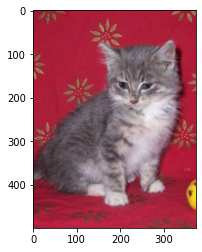

In [96]:
img = plt.imread(trn_fnames[14])
plt.imshow(img);

# Dataset and Dataloader

In [97]:
train_ds = datasets.ImageFolder(trn_dir)

In [98]:
train_ds.classes

['cat', 'dog']

In [99]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [100]:
train_ds.root

'/content/drive/MyDrive/dogVsCat/dogcat/dev/train'

In [101]:
train_ds.imgs[233]

('/content/drive/MyDrive/dogVsCat/dogcat/dev/train/cat/cat.308.jpg', 0)

# transformations

In [103]:
tfms = transforms.Compose([
                           transforms.Resize((sz, sz)),
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.244, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
#valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [104]:
len(train_ds), len(valid_ds)

(630, 3258)

# Dataloaders

In [106]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
#valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

#Dataloader

In [107]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


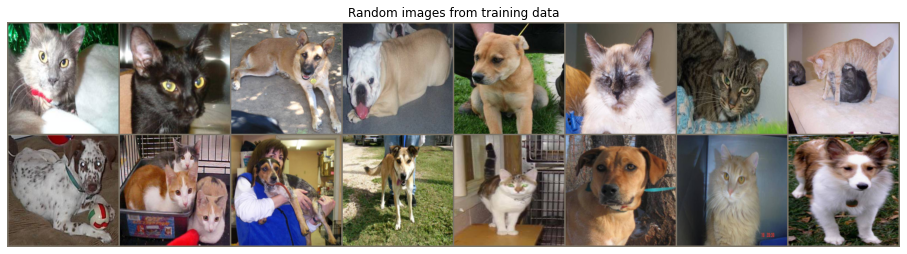

In [108]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [139]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
        )
        
        self.fc = nn.Linear(56 * 56 * 64, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = self.conv3(out)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

In [140]:
model = SimpleCNN()

# transfer model to GPU
if use_gpu:
    model = model.cuda()

In [141]:
use_gpu

True

In [142]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Linear(in_features=200704, out_features=2, bias=True)
)

## Loss function and optimizer

In [143]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

#Train

In [144]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses += [loss.data]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 10 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [ 1/10], Step [ 10/ 39], Loss: 26.5520
Epoch [ 1/10], Step [ 20/ 39], Loss: 17.5322
Epoch [ 1/10], Step [ 30/ 39], Loss: 8.8588
Epoch [ 1/10], Step [ 40/ 39], Loss: 10.9905
Epoch [ 2/10], Step [ 10/ 39], Loss: 5.9586
Epoch [ 2/10], Step [ 20/ 39], Loss: 3.9244
Epoch [ 2/10], Step [ 30/ 39], Loss: 1.9368
Epoch [ 2/10], Step [ 40/ 39], Loss: 0.7682
Epoch [ 3/10], Step [ 10/ 39], Loss: 1.0714
Epoch [ 3/10], Step [ 20/ 39], Loss: 0.5898
Epoch [ 3/10], Step [ 30/ 39], Loss: 0.5891
Epoch [ 3/10], Step [ 40/ 39], Loss: 0.5012
Epoch [ 4/10], Step [ 10/ 39], Loss: 0.4219
Epoch [ 4/10], Step [ 20/ 39], Loss: 0.5081
Epoch [ 4/10], Step [ 30/ 39], Loss: 0.4907
Epoch [ 4/10], Step [ 40/ 39], Loss: 0.6518
Epoch [ 5/10], Step [ 10/ 39], Loss: 0.4405
Epoch [ 5/10], Step [ 20/ 39], Loss: 0.5659
Epoch [ 5/10], Step [ 30/ 39], Loss: 0.3845
Epoch [ 5/10], Step [ 40/ 39], Loss: 0.3978
Epoch [ 6/10], Step [ 10/ 39], Loss: 0.2899
Epoch [ 6/10], Step [ 20/ 39], Loss: 0.4012
Epoch [ 6/10], Step [ 30/ 39]

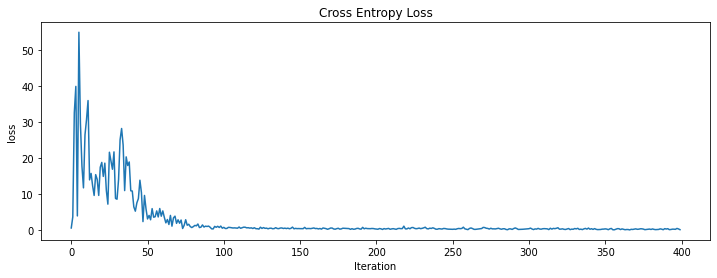

In [145]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

In [146]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [147]:
evaluate_model(model, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 54.97


In [148]:
evaluate_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 93.65


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


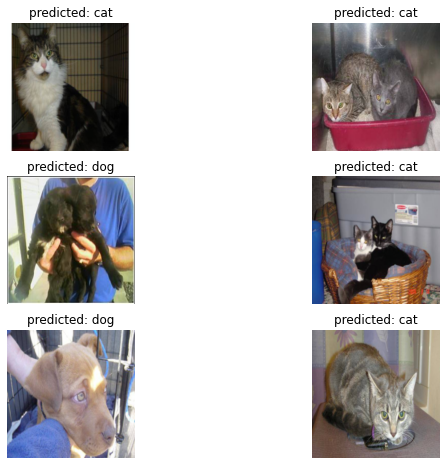

In [149]:
visualize_model(model, train_dl)

  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 204/204 [00:19<00:00, 10.64it/s]


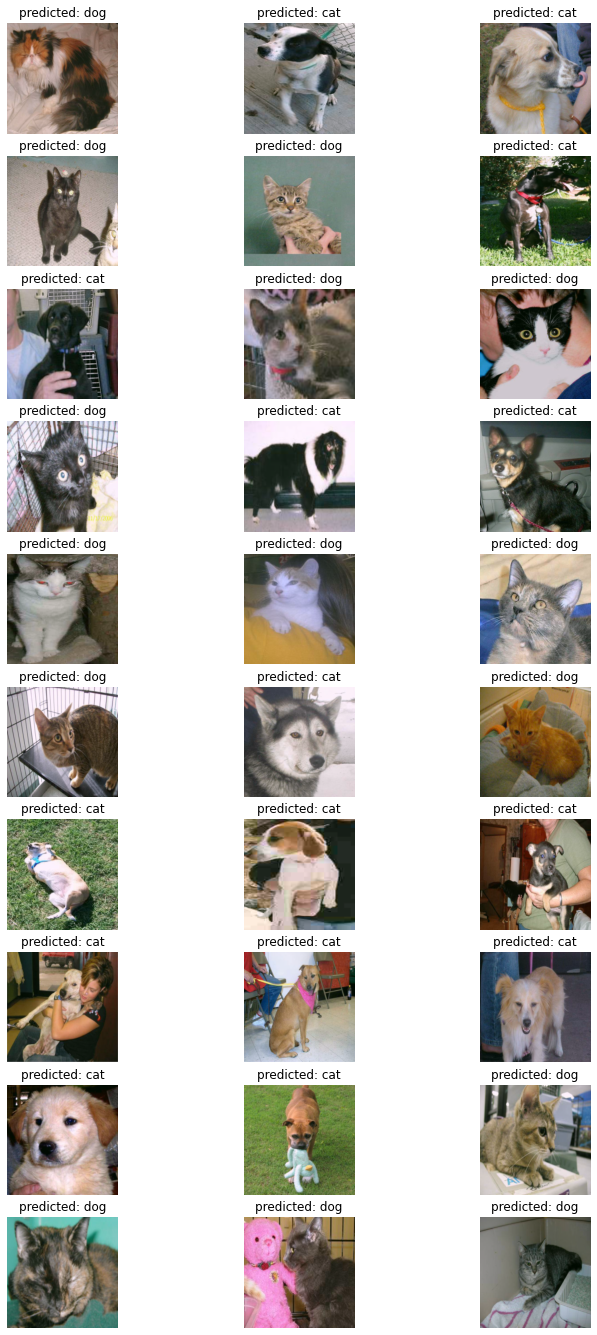

230 images out of 3258 were misclassified.


In [150]:
plot_errors(model, valid_dl)

  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 204/204 [00:16<00:00, 12.53it/s]


[[0.62682603 0.37317397]
 [0.51655251 0.48344749]]


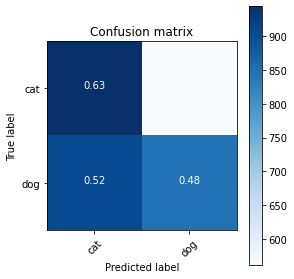

In [151]:
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))